In [1]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [2]:
### Set file names
runningLocation = 'local'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/specRepeat/'
    hisTruthFilePath='../data/raw/truth/noRepeat/'
    modTruthFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/obs_truth_output_noRepeat/' # output mod files from truth run. 
    obsFinalFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_noRepeat/' #the 'final' obs files: Verification obs, + NLmodel values from modTruth.
    modOSSEFilePath='../data/raw/OSSE_SSHSST/'
    pertFilePath='../data/raw/perturbed/'
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
    truthFilePath='/g/data/fu5/deg581/EAC_2yr_ObsVerification_HighRes/output/' # Truth file settings

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='eac_obs_'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

### Load functions

In [3]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [4]:
# Check raw SSH file

In [5]:
## raw SSH obs
raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/SSH_alongtrack_noRepeat/obs_SSH_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values, raw.obs_depth.values.mean())
print(raw.obs_Zgrid.values, raw.obs_Zgrid.values.mean())
print(raw.obs_value.values, raw.obs_value.values.mean())
print(raw.obs_type.values, raw.obs_type.values.mean())

[30. 30. 30. ... 30. 30. 30.] 30.0
[30. 30. 30. ... 30. 30. 30.] 30.0
[0.05926482 0.0570922  0.05364445 ... 0.23181389 0.23042813 0.22278285] 0.38287499415095666
[1 1 1 ... 1 1 1] 1.0


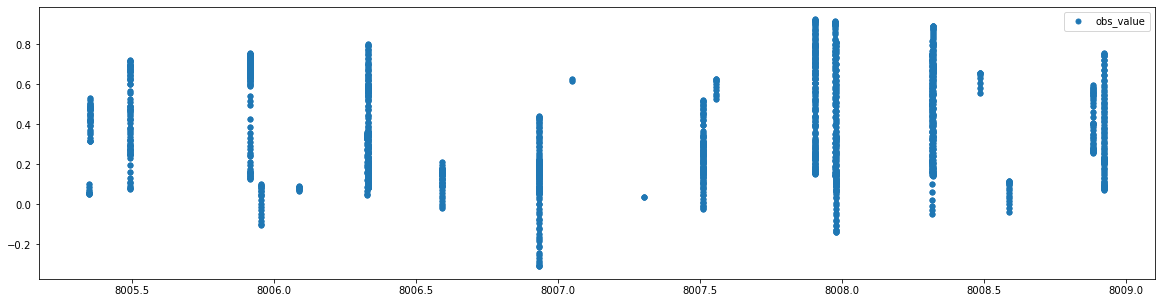

In [6]:
pRange=(405)


fig = plt.figure(figsize=(20,5))
ax = plt.axes()

vobs=raw.obs_value.where(raw.obs_provenance==pRange)
lo=raw.obs_lon.where(raw.obs_provenance==pRange)
t=raw.obs_time.where(raw.obs_provenance==pRange)
la=raw.obs_lat.where(raw.obs_provenance==pRange)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
# ax.set_xlim([8006,8006.5])


-30.239999999612337  mins
-1470.2399999996123 mins


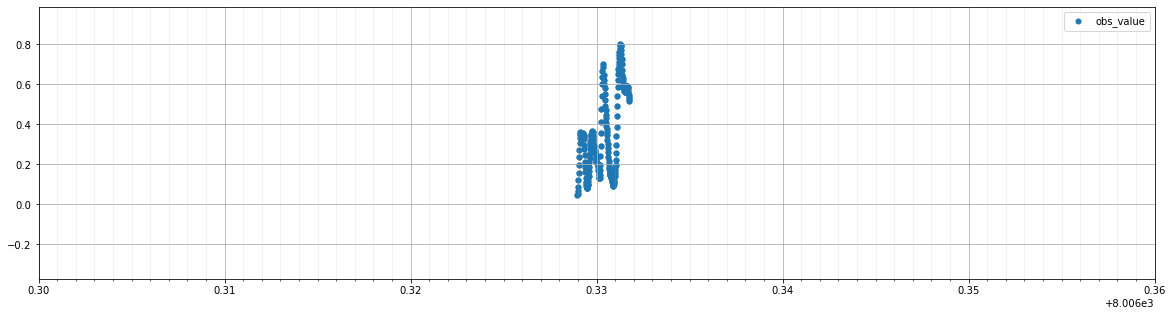

In [7]:

fig = plt.figure(figsize=(20,5))
ax = plt.axes()

pRange=405

vobs=raw.obs_value.where(raw.obs_provenance==pRange)
lo=raw.obs_lon.where(raw.obs_provenance==pRange)
t=raw.obs_time.where(raw.obs_provenance==pRange)
la=raw.obs_lat.where(raw.obs_provenance==pRange)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
ax.grid(True)
minor_ticks = np.arange(8005, 8009, .001)
ax.set_xticks(minor_ticks, minor=True), ax.grid(which='minor', alpha=0.2)
ax.set_xlim([8006.3,8006.36])

print(str((8006.309 - 8006.33)*(24*60)),' mins')
print(str((8006.33 - 8007.351)*(24*60)),'mins')

# Check obs files with repeated values wit new merge method

In [8]:
timeRange = [8001, 8033]

## 
datelist = np.array(range(timeRange[0],timeRange[1],4))

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8009.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8013.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8017.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8021.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8025.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8029.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs

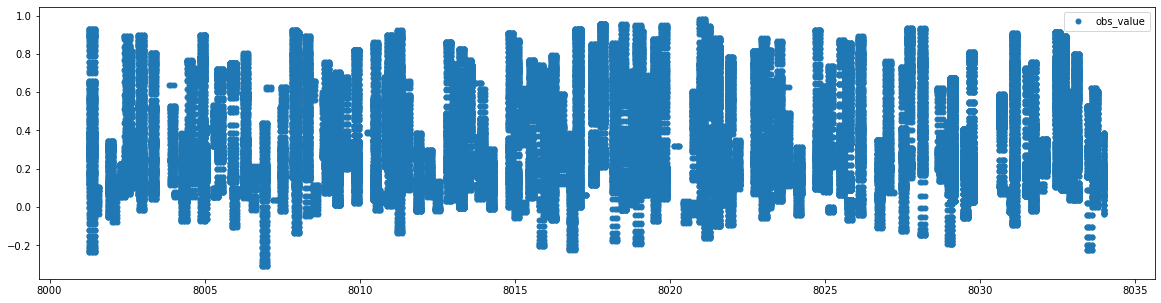

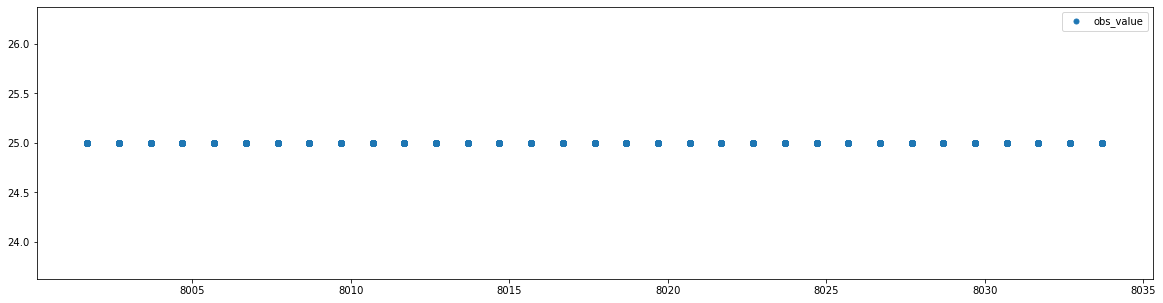

In [9]:
pRange=(405)

obsVerifFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/' # outputted obs files from ROMS_ObsPrep, that are supplied to first truth run


fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()

pRange=(340)

#%matplotlib qt 
fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
plt.show()

    # pRange=(340)
    # v=mod.NLmodel_final.where(obs.obs_provenance==pRange)
    # vi=mod.NLmodel_initial.where(obs.obs_provenance==pRange)
    # vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    # lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    # la=obs.obs_lat.where(obs.obs_provenance==pRange)
    # t=obs.obs_time.where(obs.obs_provenance==pRange)
    # fig = plt.figure(figsize=(10,5))
    # ax = plt.axes()
    # ax.plot(t, v, marker='.', markersize=1, lineStyle='None',label='NLmodel_final',zorder=10)
    # ax.plot(t, vi, marker='.', markersize=5, lineStyle='None',label='NLmodel_initial',zorder=5)
    # ax.plot(t, vobs, marker='.', markersize=10, lineStyle='None',label='obs_value',zorder=1)
    # ax.legend()
    # print(v.mean())

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8005.nc
-30.239999999612337  mins
-30.239999999612337 mins


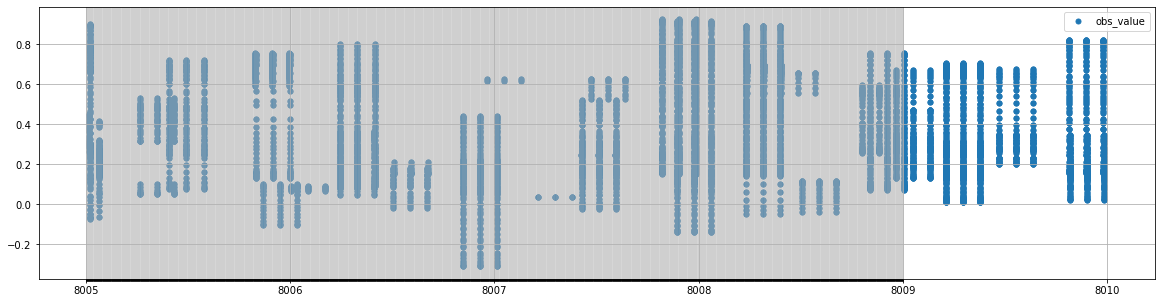

In [19]:
obsVerifFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/' # outputted obs files from ROMS_ObsPrep, that are supplied to first truth run

fig = plt.figure(figsize=(20,5))
ax = plt.axes()

pRange=405
for dates in np.array([8005]):

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
ax.grid(True)
minor_ticks = np.arange(8005, 8009, .001)
ax.set_xticks(minor_ticks, minor=True), ax.grid(which='minor', alpha=0.2)
# ax.set_xlim([8006.23,8006.43])

print(str((8006.309 - 8006.33)*(24*60)),' mins')
print(str((8006.33 - 8006.351)*(24*60)),'mins')


loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final/eac_obs_8005.nc
-30.239999999612337  mins
-30.239999999612337 mins


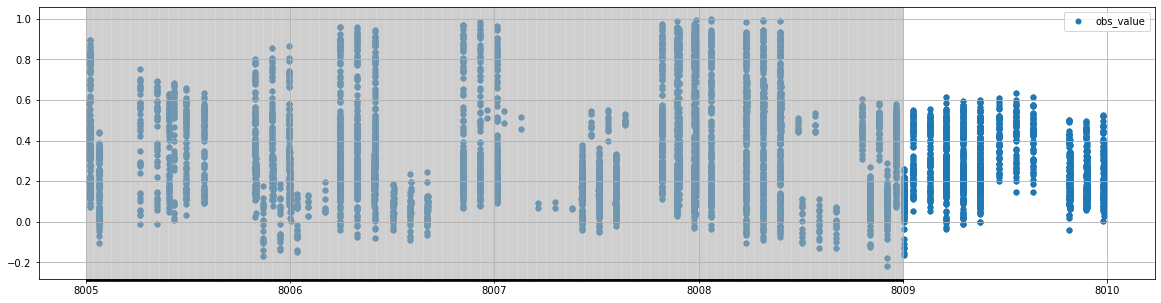

In [15]:


obsFinalFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final/' # outputted obs files from ROMS_ObsPrep, that are supplied to first truth run


fig = plt.figure(figsize=(20,5))
ax = plt.axes()

pRange=405
for dates in np.array([8005]):

    filenameObs=obsFinalFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
ax.grid(True)
minor_ticks = np.arange(8005, 8009, .001)
ax.set_xticks(minor_ticks, minor=True), ax.grid(which='minor', alpha=0.2)
ax.set_xlim([8006.23,8006.43])

print(str((8006.309 - 8006.33)*(24*60)),' mins')
print(str((8006.33 - 8006.351)*(24*60)),'mins')


# Plot up file from single track with this new merge method

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8009.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8013.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8017.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8021.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8025.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8029.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRep

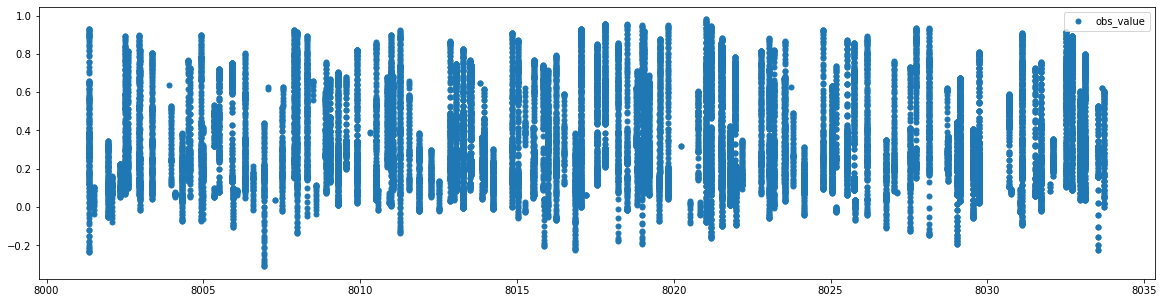

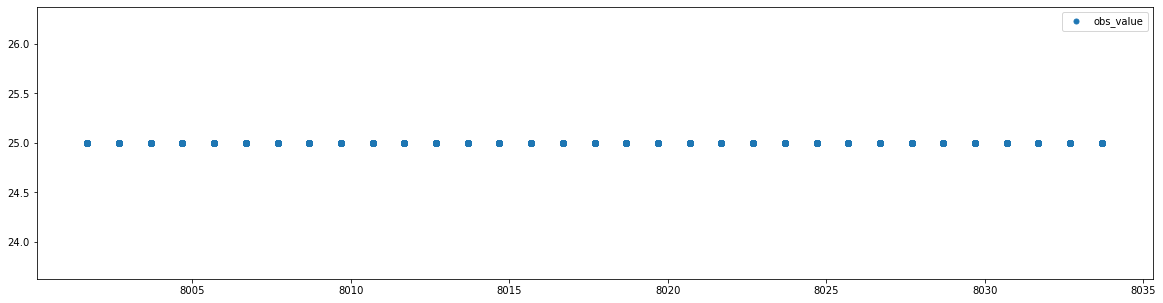

In [11]:
pRange=(405)

obsVerifFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/' # outputted obs files from ROMS_ObsPrep, that are supplied to first truth run


fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()

pRange=(340)

#%matplotlib qt 
fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
plt.show()

    # pRange=(340)
    # v=mod.NLmodel_final.where(obs.obs_provenance==pRange)
    # vi=mod.NLmodel_initial.where(obs.obs_provenance==pRange)
    # vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    # lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    # la=obs.obs_lat.where(obs.obs_provenance==pRange)
    # t=obs.obs_time.where(obs.obs_provenance==pRange)
    # fig = plt.figure(figsize=(10,5))
    # ax = plt.axes()
    # ax.plot(t, v, marker='.', markersize=1, lineStyle='None',label='NLmodel_final',zorder=10)
    # ax.plot(t, vi, marker='.', markersize=5, lineStyle='None',label='NLmodel_initial',zorder=5)
    # ax.plot(t, vobs, marker='.', markersize=10, lineStyle='None',label='obs_value',zorder=1)
    # ax.legend()
    # print(v.mean())

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_noRepeat/eac_obs_8005.nc
-30.239999999612337  mins
-30.239999999612337 mins


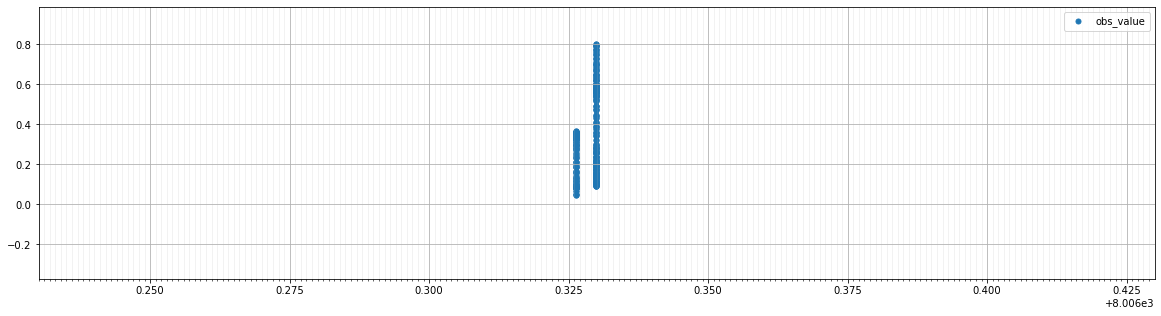

In [12]:

fig = plt.figure(figsize=(20,5))
ax = plt.axes()

pRange=405
for dates in np.array([8005]):

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
ax.grid(True)
minor_ticks = np.arange(8005, 8009, .001)
ax.set_xticks(minor_ticks, minor=True), ax.grid(which='minor', alpha=0.2)
ax.set_xlim([8006.23,8006.43])

print(str((8006.309 - 8006.33)*(24*60)),' mins')
print(str((8006.33 - 8006.351)*(24*60)),'mins')


In [13]:
STOP

NameError: name 'STOP' is not defined

       opening 08001.nc
8001
<xarray.DataArray 'NLmodel_value' ()>
array(0.27189167)
8002
<xarray.DataArray 'NLmodel_value' ()>
array(0.31029313)
8003
<xarray.DataArray 'NLmodel_value' ()>
array(0.35569925)
8004
<xarray.DataArray 'NLmodel_value' ()>
array(0.24213643)
8005
<xarray.DataArray 'NLmodel_value' ()>
array(0.33915056)
8001
<xarray.DataArray 'NLmodel_value' ()>
array(20.80996858)
8002
<xarray.DataArray 'NLmodel_value' ()>
array(23.05239555)
8003
<xarray.DataArray 'NLmodel_value' ()>
array(22.81737855)
8004
<xarray.DataArray 'NLmodel_value' ()>
array(20.04837455)
8005
<xarray.DataArray 'NLmodel_value' ()>
array(20.35744286)
       opening 08005.nc
8005
<xarray.DataArray 'NLmodel_value' ()>
array(0.33929024)
8006
<xarray.DataArray 'NLmodel_value' ()>
array(0.3361016)
8007
<xarray.DataArray 'NLmodel_value' ()>
array(0.37365367)
8008
<xarray.DataArray 'NLmodel_value' ()>
array(0.34100148)
8009
<xarray.DataArray 'NLmodel_value' ()>
array(0.28120211)
8005
<xarray.DataArray 'NLmodel_v

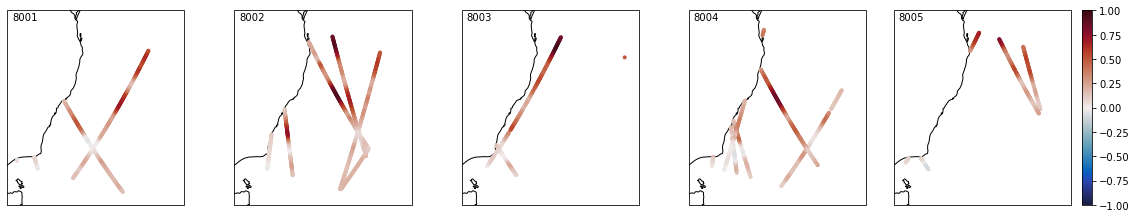

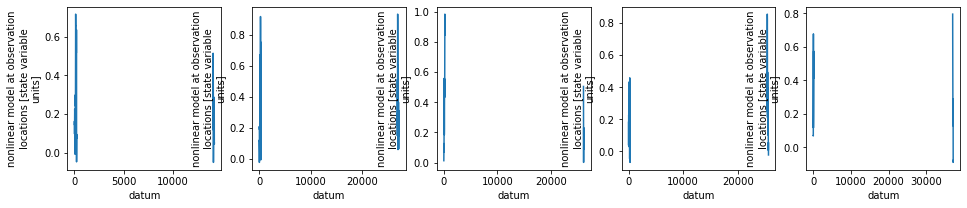

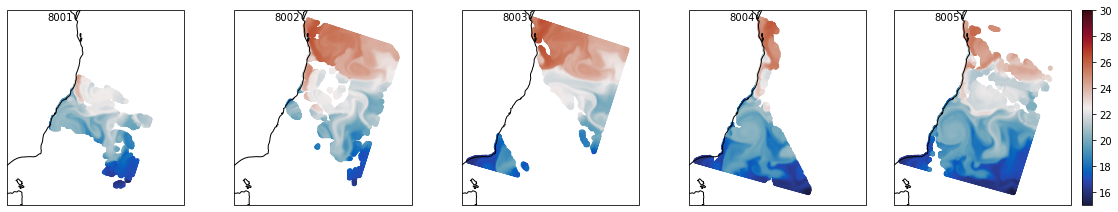

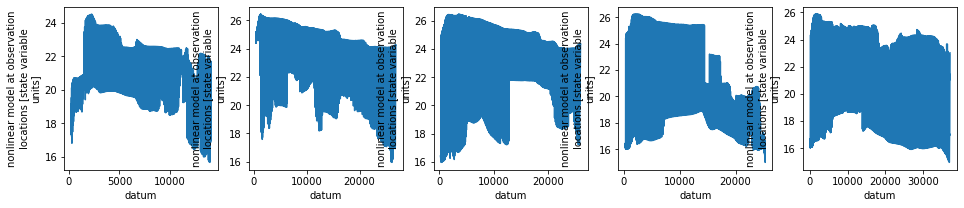

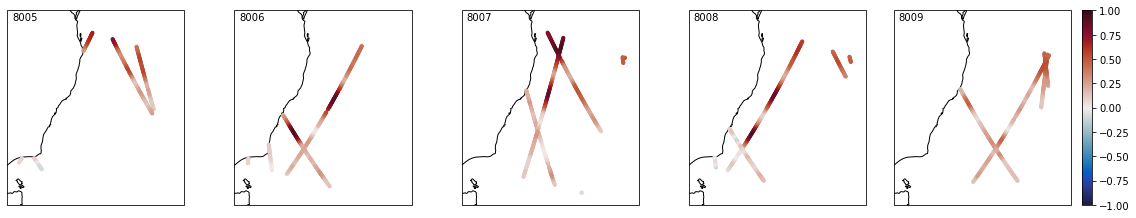

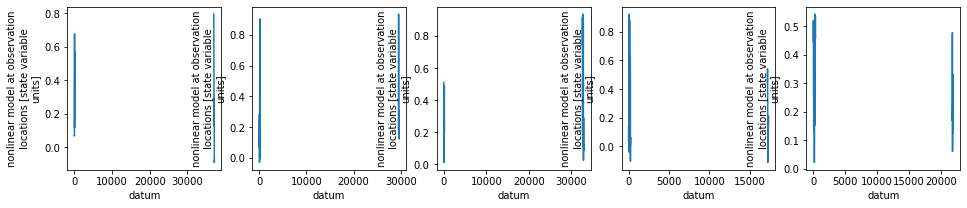

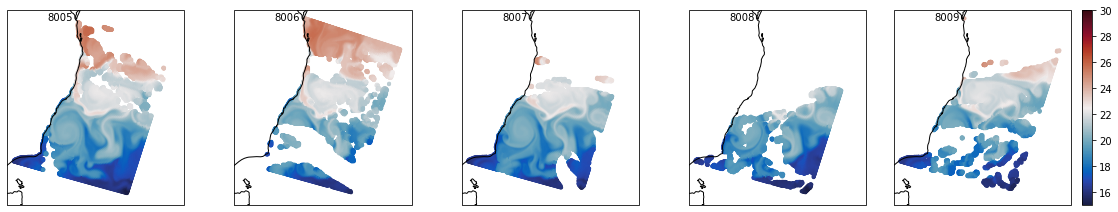

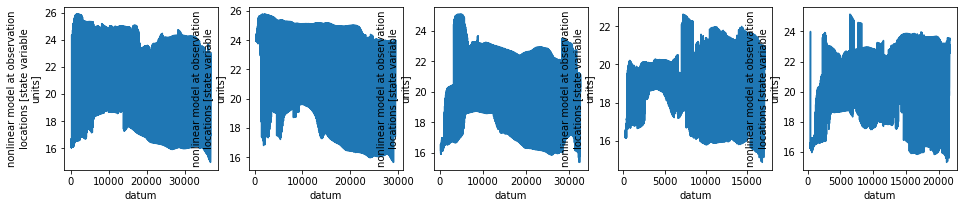

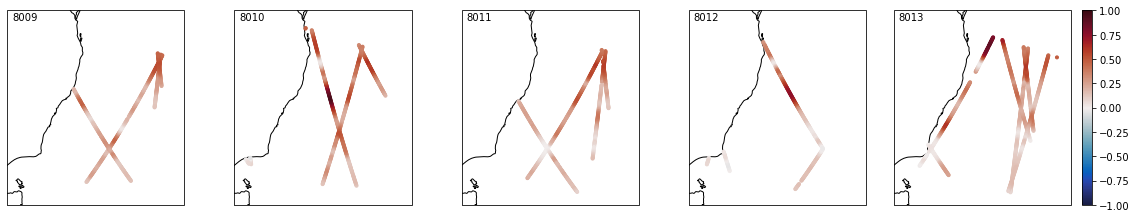

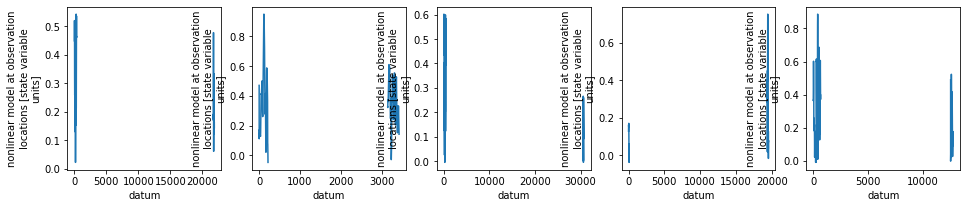

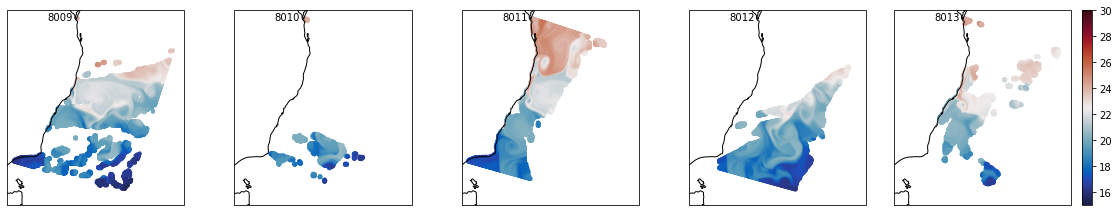

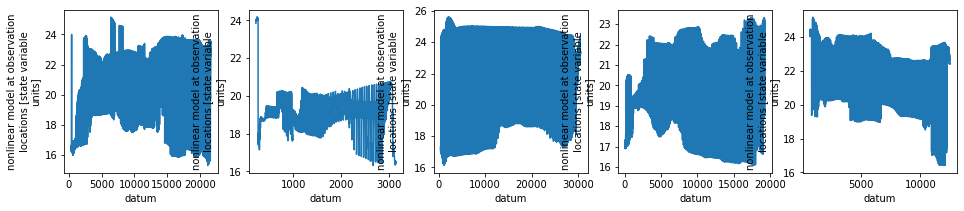

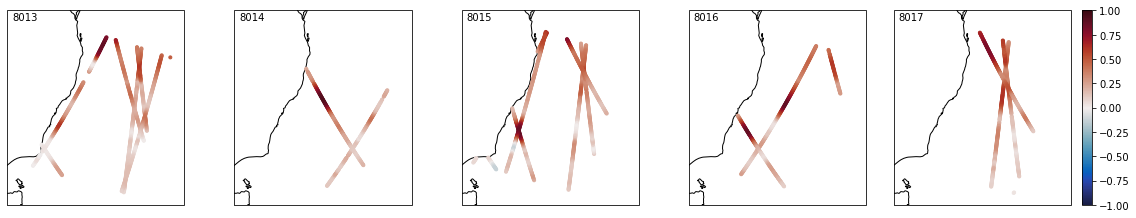

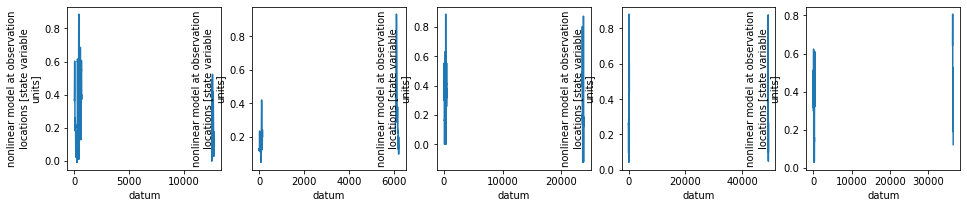

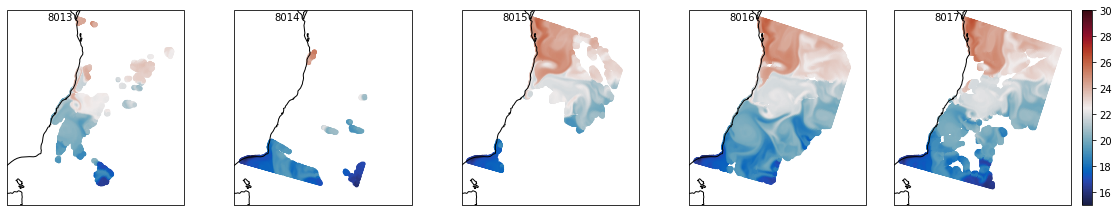

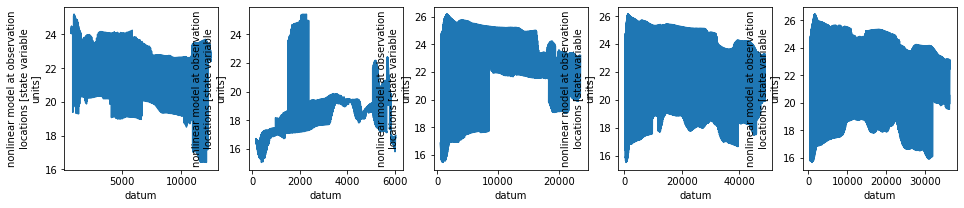

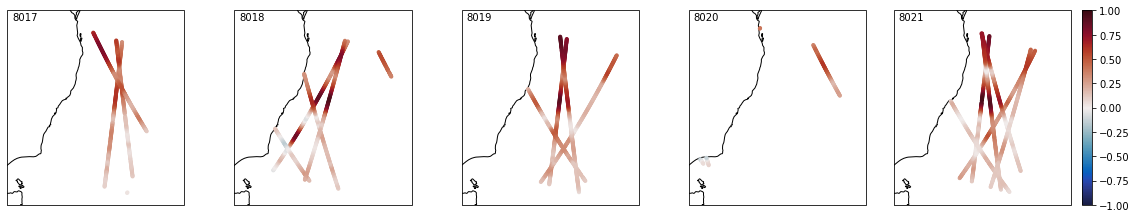

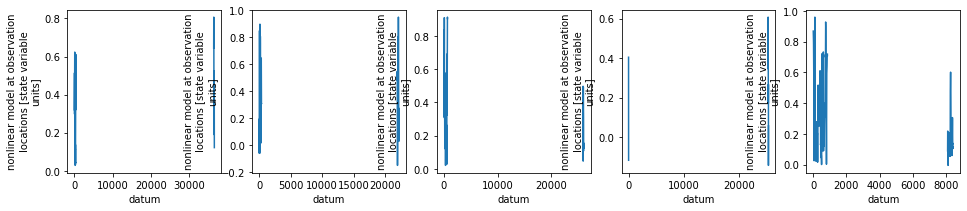

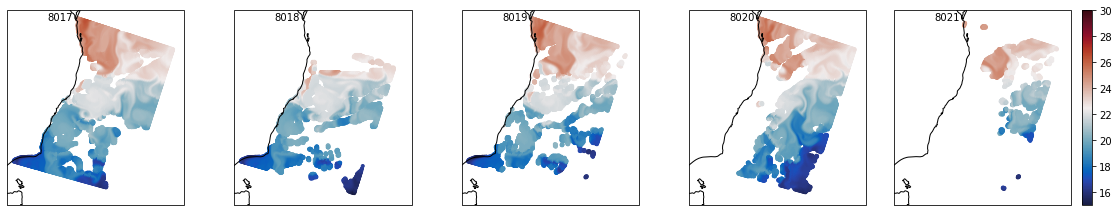

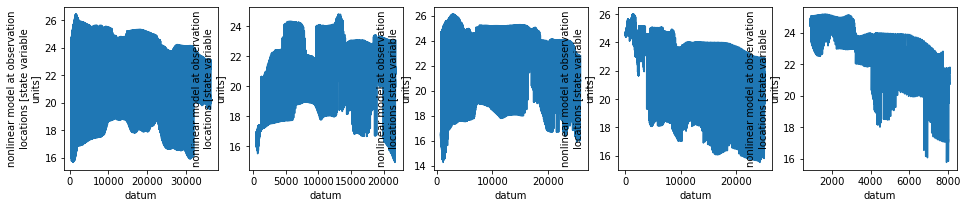

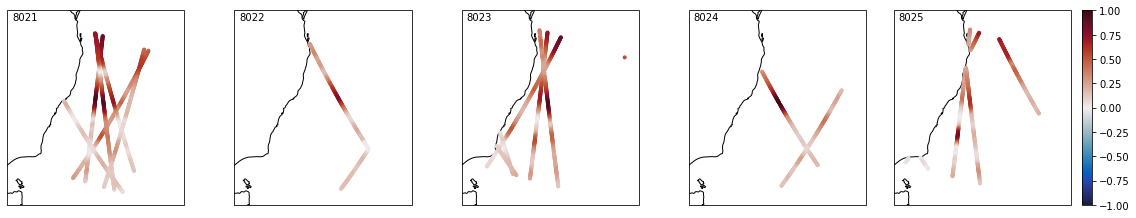

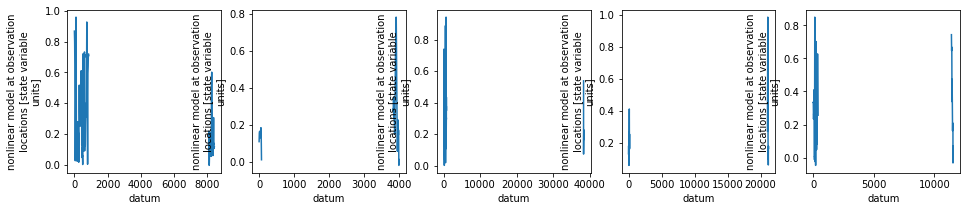

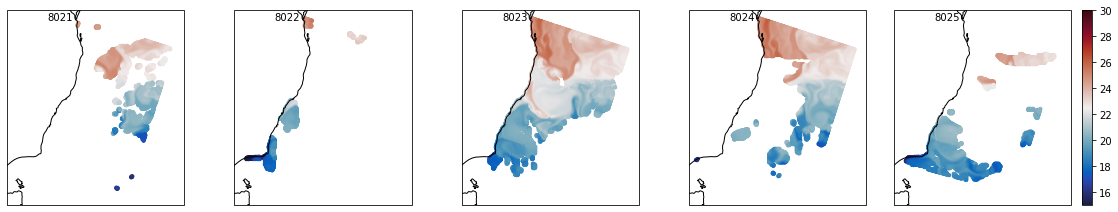

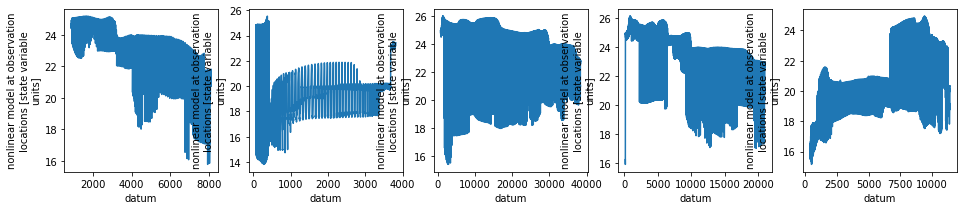

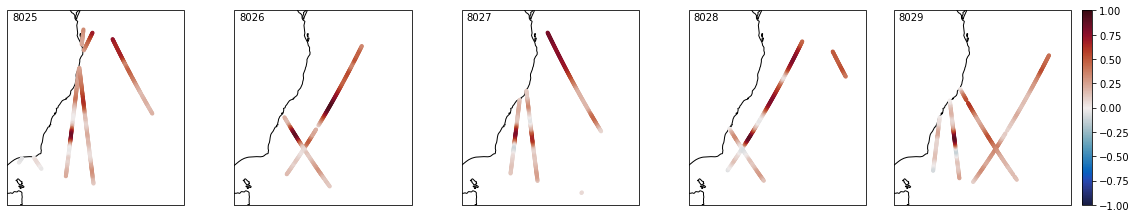

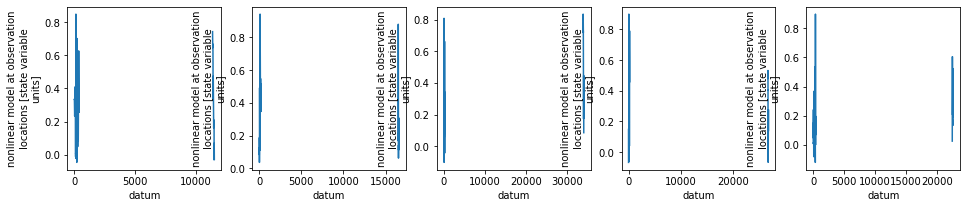

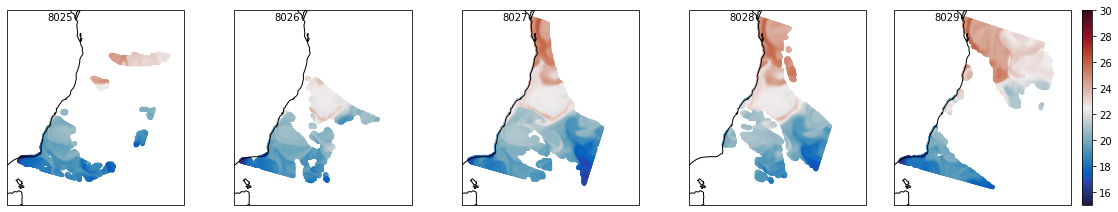

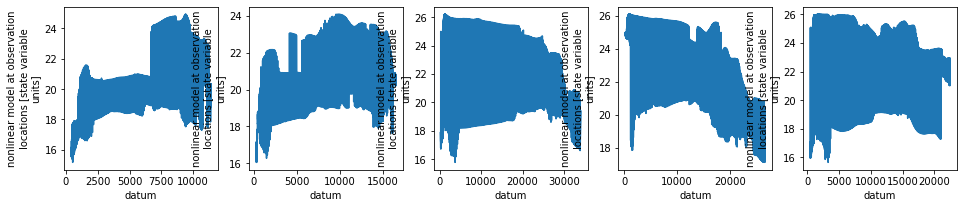

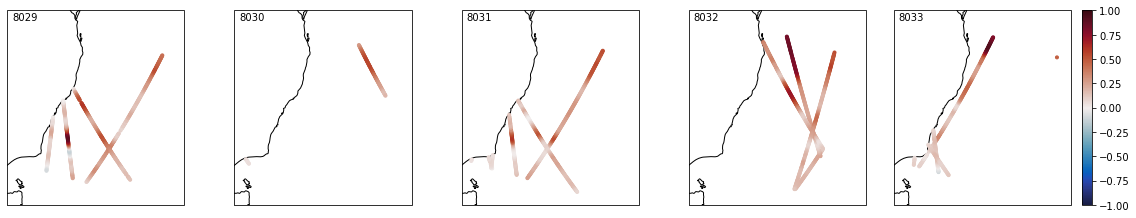

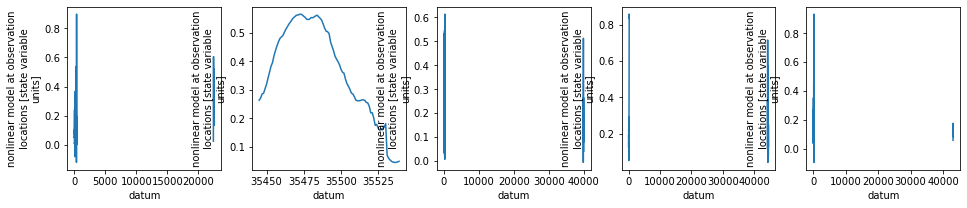

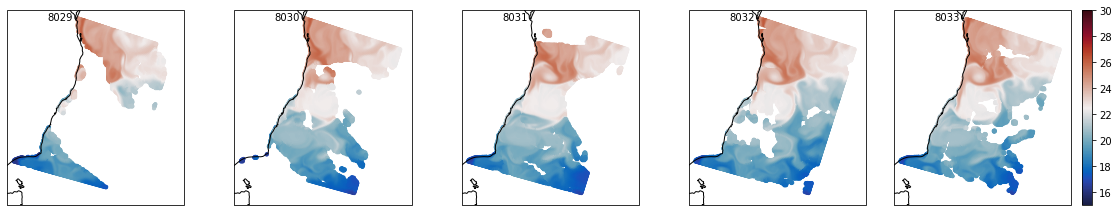

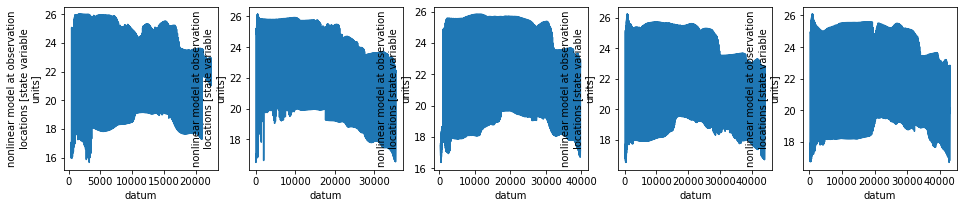

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
aa=0/24


for day in datelist: 
    modFileName = '0'+str(day)+'.nc'
    modPath = modTruthFilePath+prefixMod+modFileName
    print('       opening '+modFileName)
    mod = xr.open_dataset(modPath)



    pRange=(405)
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
        ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
    plt.tight_layout()
    fig.colorbar(sc)

    pRange=(405)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        print(tRangeStart)
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        v.plot(ax=ax)
        print(v.mean())

    pRange=(340)
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
        ax.text(.3,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([15,30])
    plt.tight_layout()
    fig.colorbar(sc)

    pRange=(340)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        print(tRangeStart)
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        v.plot(ax=ax)
        print(v.mean())


# Now look at the finalised obs file.


       opening 8017.nc


<xarray.Dataset>
Dimensions:         (datum: 125319, state_variable: 7, survey: 101)
Dimensions without coordinates: datum, state_variable, survey
Data variables: (12/15)
    spherical       int32 ...
    Nobs            (survey) int32 ...
    survey_time     (survey) float64 ...
    obs_variance    (state_variable) float64 ...
    obs_type        (datum) int32 ...
    obs_time        (datum) float64 ...
    ...              ...
    obs_Zgrid       (datum) float64 ...
    obs_error       (datum) float64 ...
    obs_value       (datum) float64 ...
    obs_provenance  (datum) int32 ...
    obs_lat         (datum) float64 ...
    obs_lon         (datum) float64 ...
Attributes:
    title:            Observations
    author:           dave
    date:             17-Jul-2021 12:37:51
    type:             ROMS observations
    Conventions:      CF-1.4
    state_variables:  \n1: free-surface (m) \n2: vertically integrated u-mome...

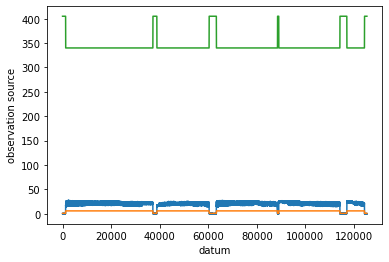

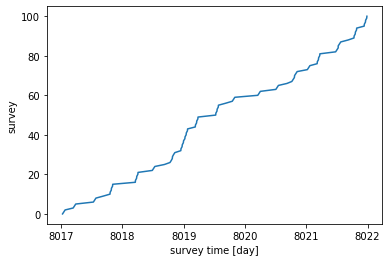

In [ ]:
day = '8017'
obsFileName = ''+str(day)+'.nc'
obsPath = obsFinalFilePath+prefixObs+obsFileName
print('       opening '+obsFileName)
obs = xr.open_dataset(obsPath)

obs.obs_value.plot()

obs.obs_type.plot()
obs.obs_provenance.plot()

plt.figure()
obs.survey_time.plot(y='survey')

obs

In [ ]:


for day in datelist: 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsFinalFilePath+prefixObs+obsFileName
    print('       opening '+obsFileName)
    obs = xr.open_dataset(obsPath)


    # SST
    print('obs_depth',obs.obs_depth.where(obs.obs_provenance==340, drop=True).values, obs.obs_depth.where(obs.obs_provenance==340, drop=True).values.mean())
    print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==340, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==340, drop=True).values.mean())
    print('obs_value',obs.obs_value.where(obs.obs_provenance==340, drop=True).values, obs.obs_value.where(obs.obs_provenance==340, drop=True).values.mean())
    print('obs_type',obs.obs_type.where(obs.obs_provenance==340, drop=True).values, obs.obs_type.where(obs.obs_provenance==340, drop=True).values.mean())
    print('obs_time',obs.obs_time.where(obs.obs_provenance==340, drop=True).values)

    ## SSH
    print('obs_depth',obs.obs_depth.where(obs.obs_provenance==405, drop=True).values, obs.obs_depth.where(obs.obs_provenance==405, drop=True).values.mean())
    print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==405, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==405, drop=True).values.mean())
    print('obs_value',obs.obs_value.where(obs.obs_provenance==405, drop=True).values, obs.obs_value.where(obs.obs_provenance==405, drop=True).values.mean())
    print('obs_type',obs.obs_type.where(obs.obs_provenance==405, drop=True).values, obs.obs_type.where(obs.obs_provenance==405, drop=True).values.mean())
    print('obs_time',obs.obs_time.where(obs.obs_provenance==405, drop=True).values) 

       opening 8001.nc
obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [30. 30. 30. ... 30. 30. 30.] 30.0
obs_value [18.34816683 18.68380498 17.97309418 ... 23.43108693 23.30553631
 23.09458863] 21.399842922133683
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
obs_time [8001.68735222 8001.68735222 8001.68735222 ... 8005.68692876 8005.68692876
 8005.68692876]
obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [30. 30. 30. ... 30. 30. 30.] 30.0
obs_value [ 0.10240447  0.14594036  0.23859404 ... -0.12811737 -0.09093764
 -0.06306419] 0.2935751682693948
obs_type [1. 1. 1. ... 1. 1. 1.] 1.0
obs_time [8001.34707444 8001.34707444 8001.34707444 ... 8005.97165098 8005.97165098
 8005.97165098]
       opening 8005.nc
obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [30. 30. 30. ... 30. 30. 30.] 30.0
obs_value [16.56341221 17.09097988 16.36582787 ... 23.68624792 24.00149775
 24.02771744] 20.461500685342553
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
obs_time [8005.68692876 8005.68692876 8005.686928

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_Repeat/eac_obs_8005.nc
-30.239999999612337  mins
-29.663999999756925 mins


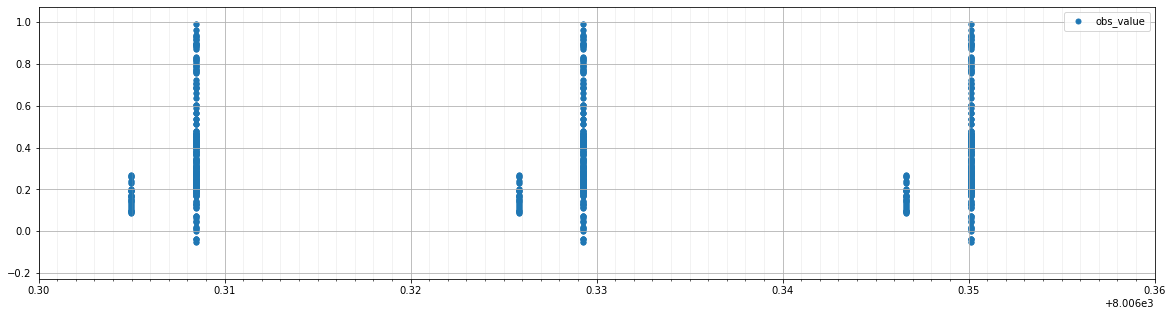

In [ ]:

fig = plt.figure(figsize=(20,5))
ax = plt.axes()

pRange=405
for dates in np.array([8005]):

    filenameObs=obsFinalFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
ax.grid(True)
minor_ticks = np.arange(8005, 8009, .001)
ax.set_xticks(minor_ticks, minor=True), ax.grid(which='minor', alpha=0.2)
ax.set_xlim([8006.3,8006.36])

print(str((8006.305 - 8006.326)*(24*60)),' mins')
print(str((8006.326 - 8006.3466)*(24*60)),'mins')


       opening 8001.nc
8001
<xarray.DataArray 'obs_value' ()>
array(0.27174155)
8002
<xarray.DataArray 'obs_value' ()>
array(0.30952214)
8003
<xarray.DataArray 'obs_value' ()>
array(0.35372226)
8004
<xarray.DataArray 'obs_value' ()>
array(0.24287923)
8005
<xarray.DataArray 'obs_value' ()>
array(0.32255129)
8001
<xarray.DataArray 'obs_value' ()>
array(20.80894507)
8002
<xarray.DataArray 'obs_value' ()>
array(23.05180251)
8003
<xarray.DataArray 'obs_value' ()>
array(22.81261175)
8004
<xarray.DataArray 'obs_value' ()>
array(20.05080529)
8005
<xarray.DataArray 'obs_value' ()>
array(20.36104204)
       opening 8005.nc
8005
<xarray.DataArray 'obs_value' ()>
array(0.32255129)
8006
<xarray.DataArray 'obs_value' ()>
array(0.33792988)
8007
<xarray.DataArray 'obs_value' ()>
array(0.37095603)
8008
<xarray.DataArray 'obs_value' ()>
array(0.34473316)
8009
<xarray.DataArray 'obs_value' ()>
array(0.27929502)
8005
<xarray.DataArray 'obs_value' ()>
array(20.36104204)
8006
<xarray.DataArray 'obs_value' (

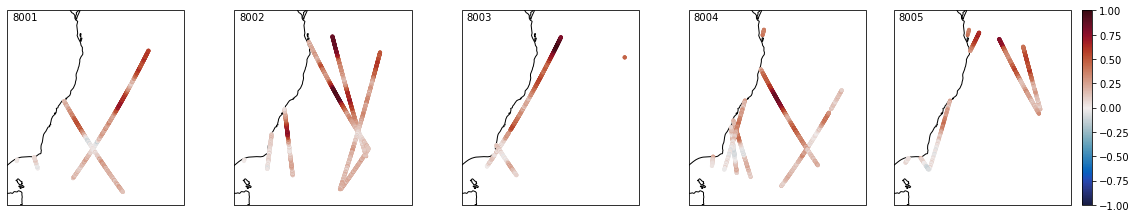

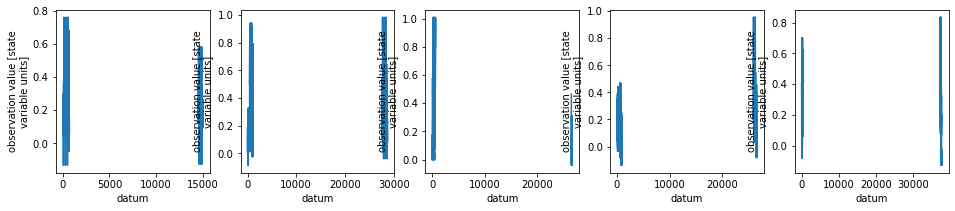

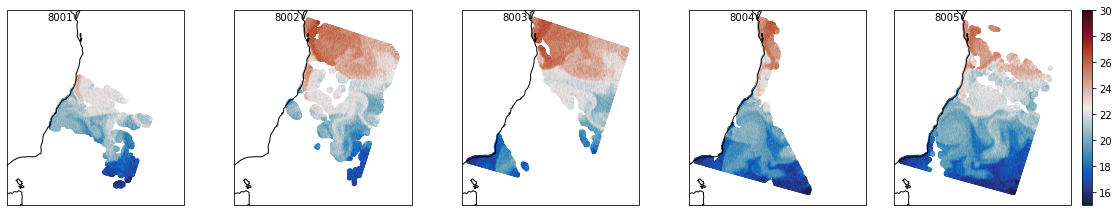

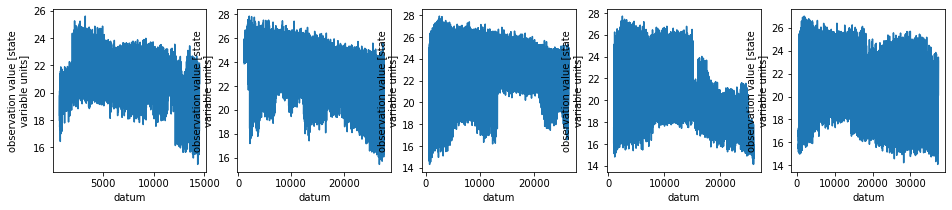

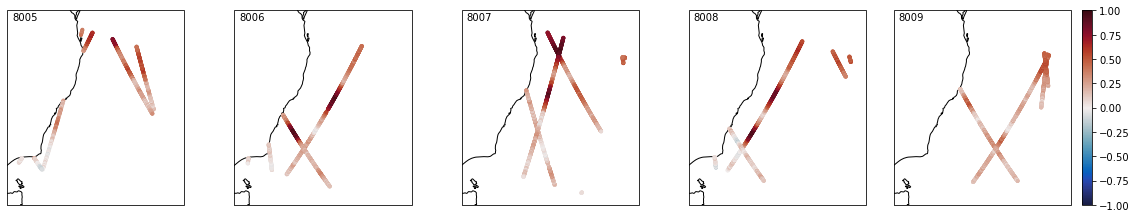

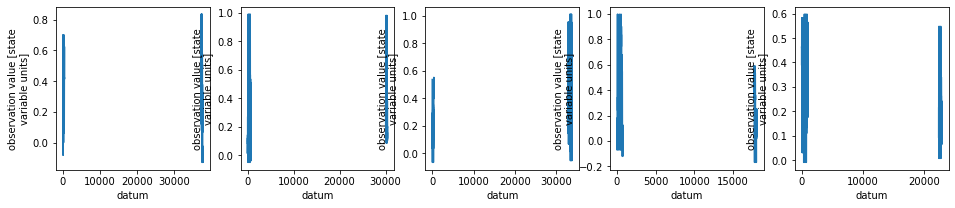

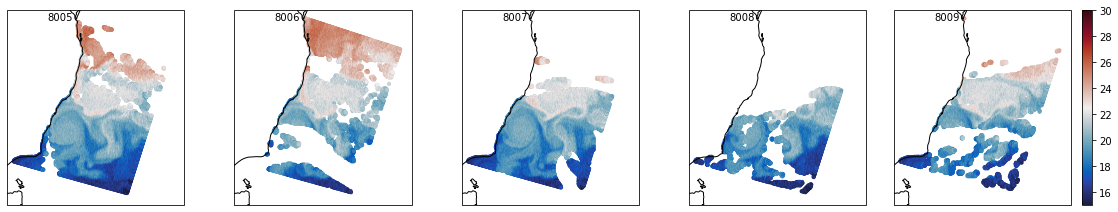

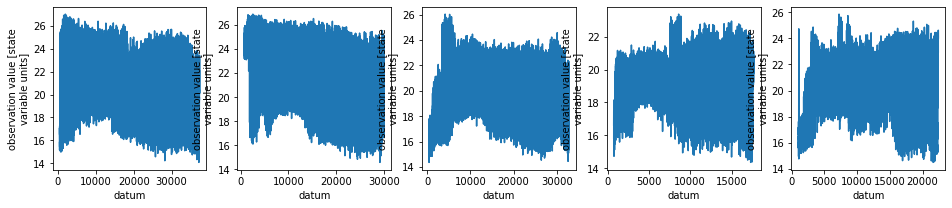

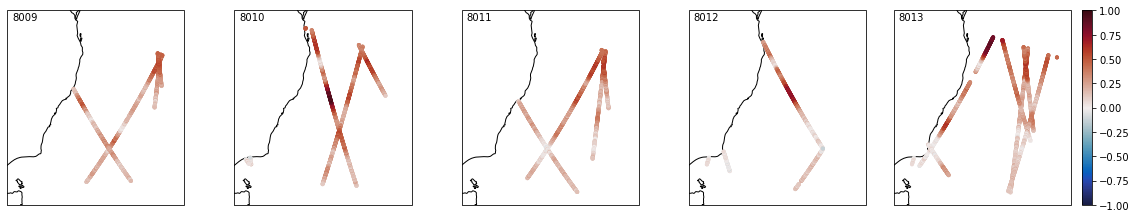

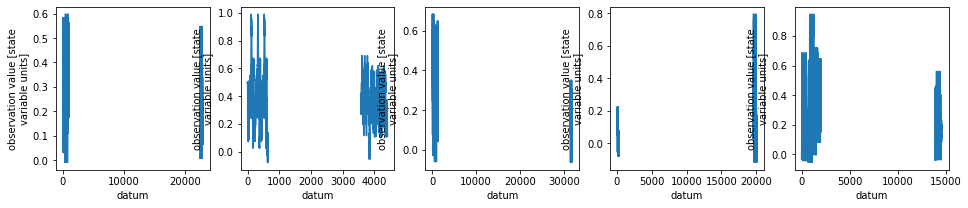

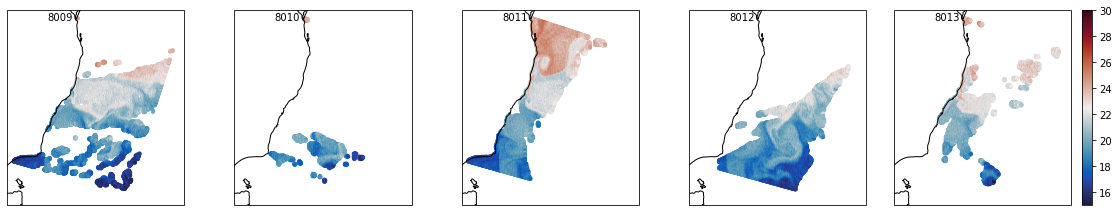

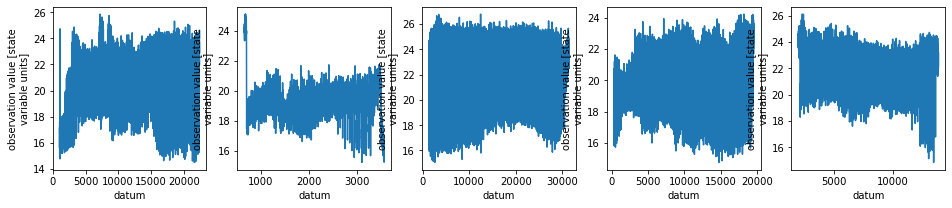

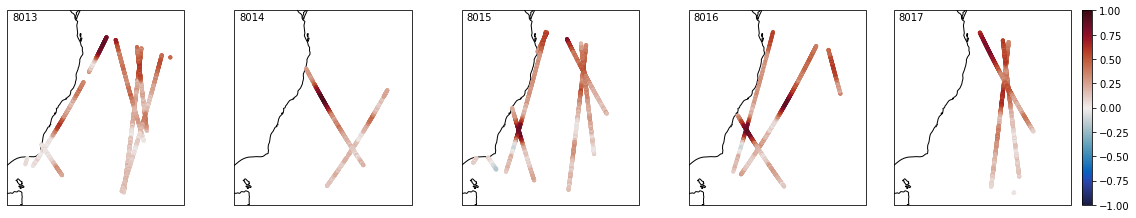

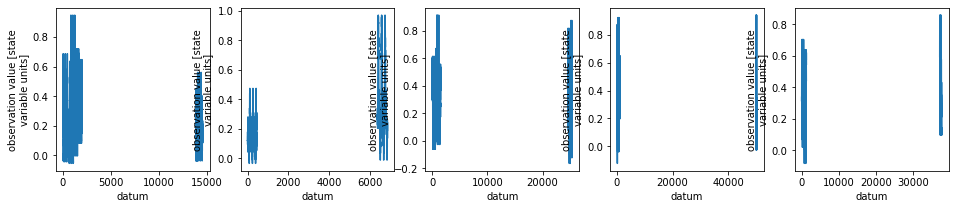

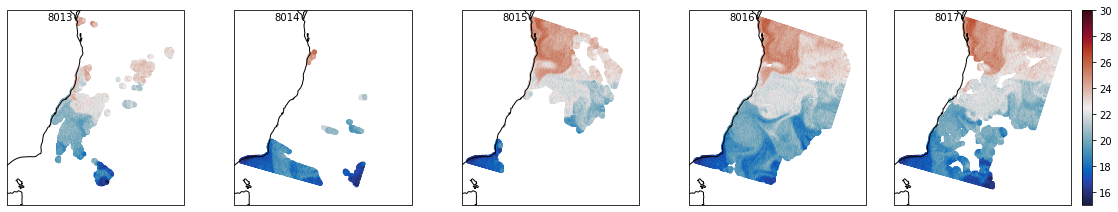

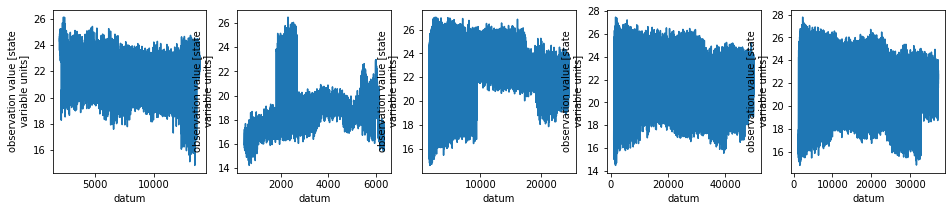

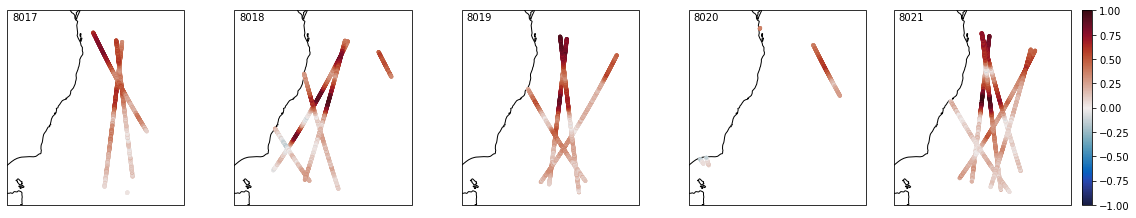

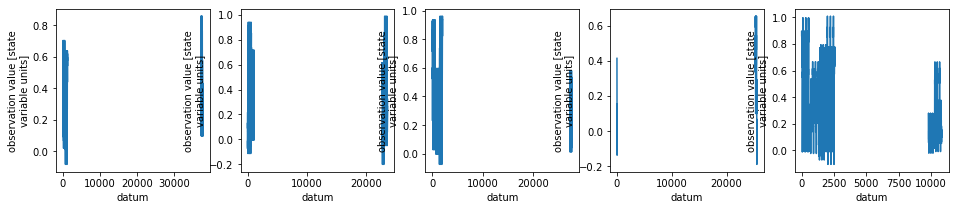

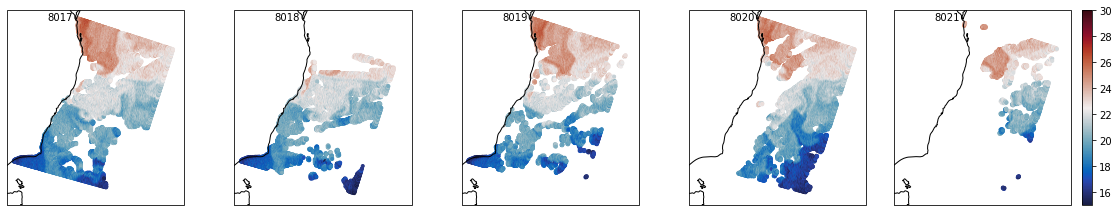

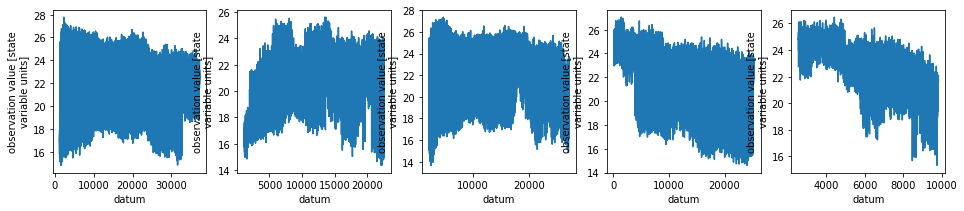

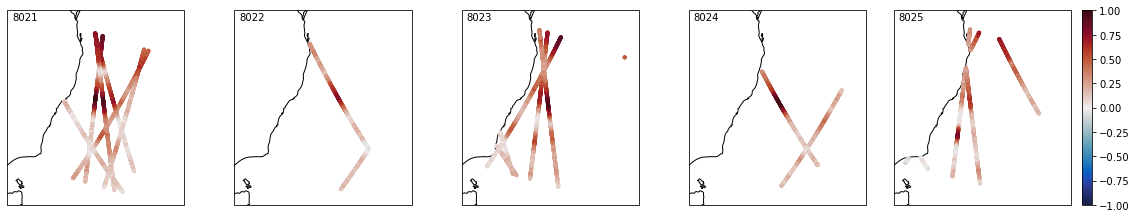

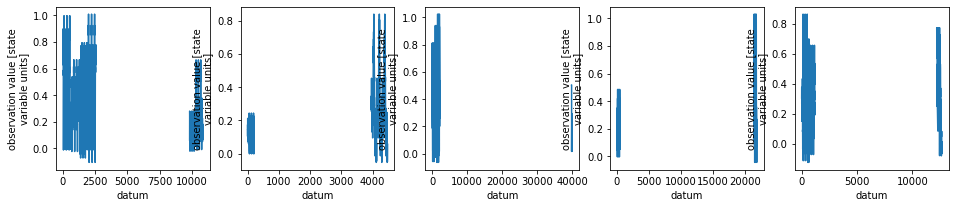

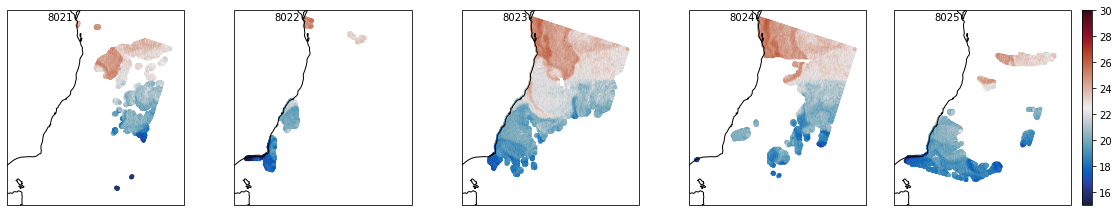

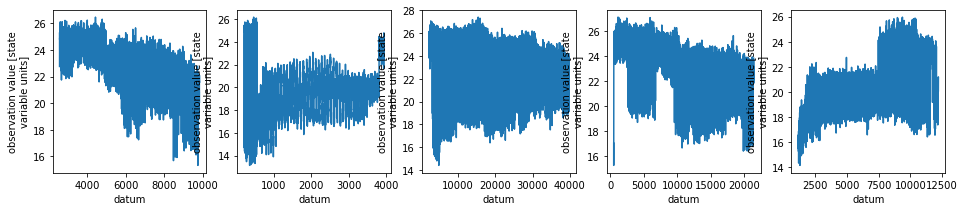

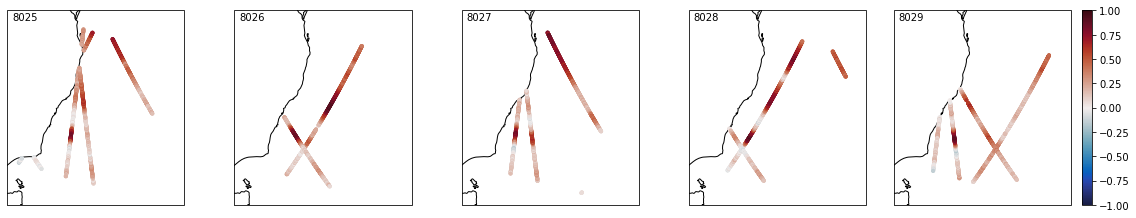

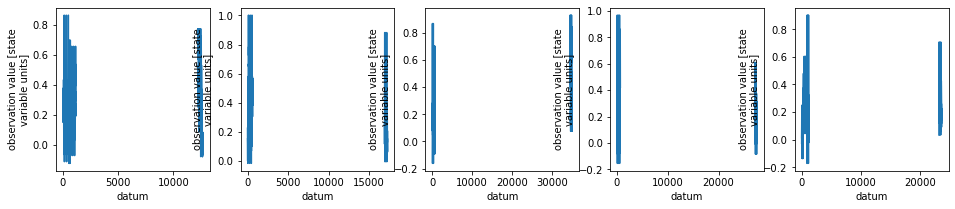

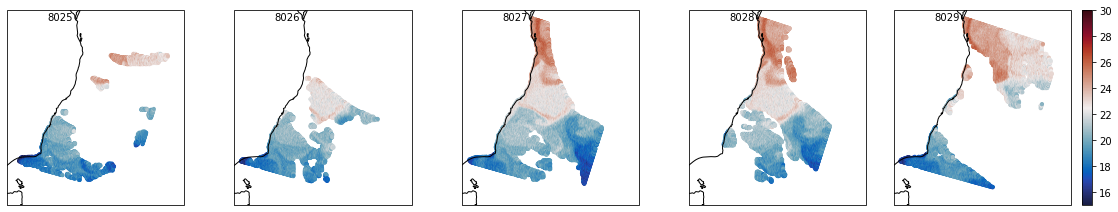

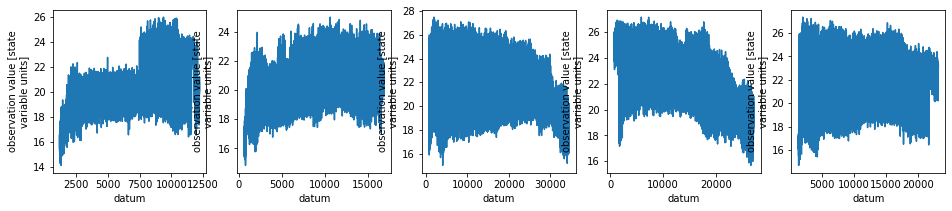

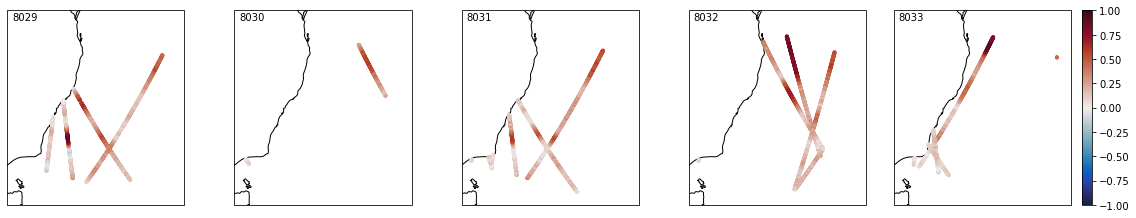

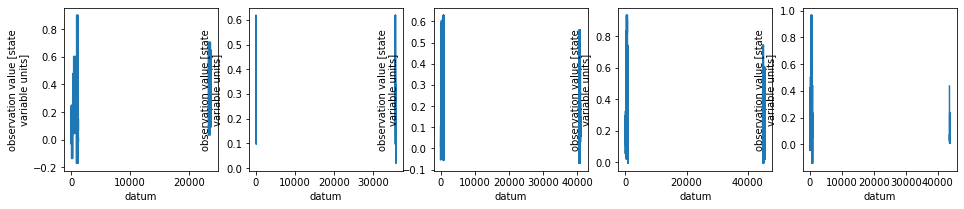

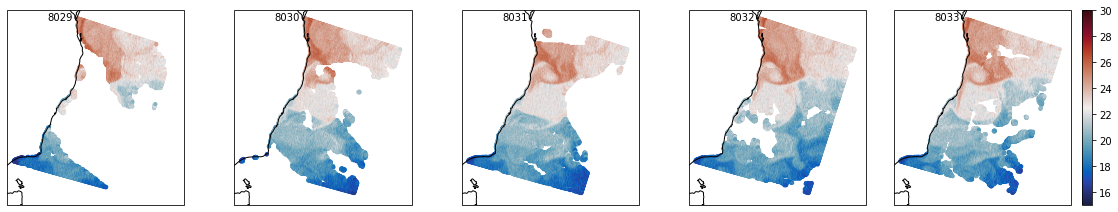

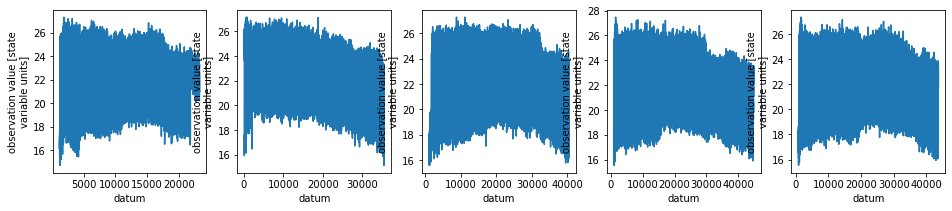

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
aa=0/24


for day in datelist: 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsFinalFilePath+prefixObs+obsFileName
    print('       opening '+obsFileName)
    obs = xr.open_dataset(obsPath)


    pRange=(405)
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
        ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
    plt.tight_layout()
    fig.colorbar(sc)

    pRange=(405)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        print(tRangeStart)
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        v.plot(ax=ax)
        print(v.mean())

    pRange=(340)
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
        ax.text(.3,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([15,30])
    plt.tight_layout()
    fig.colorbar(sc)

    pRange=(340)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        print(tRangeStart)
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        v.plot(ax=ax)
        print(v.mean())


In [ ]:
timeRange = [8005, 8017]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [ ]:
# ### Open truth file
# OverlappedTruthFiles = 'yes'
# if OverlappedTruthFiles == 'yes':
#     truth = loadOverlappedNetcdf(truthFilePath,prefixTruth,filestring='0800*.nc',overlapDays=7)
# elif OverlappedTruthFiles == 'no':
#     import glob
#     chunks = {'ocean_time':1}

#     filelist = sorted(glob.glob(truthFilePath+prefixTruth+'0800*.nc'))
#     #datelist = np.array(range(timeRange[0],timeRange[1],4))

#     for files in filelist: 
#         print(files)
#         # filelist.append(files)
#     truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
#     # truth = dropDuplicateTimes(truth)

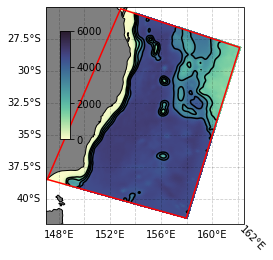

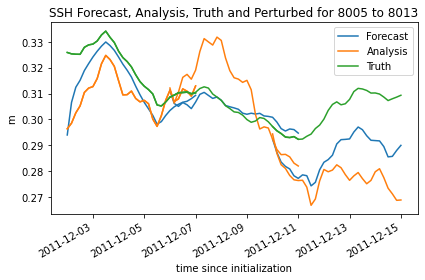

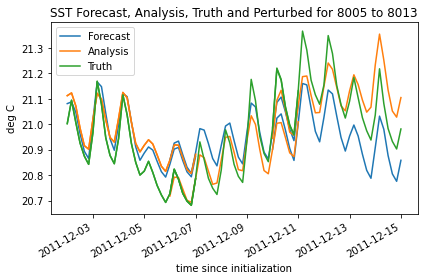

In [ ]:
### Now same but for 'upstream' area

etaRangeMetric = [0, 315] #[115, 200]
xiRangeMetric = [0, 270] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =pertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

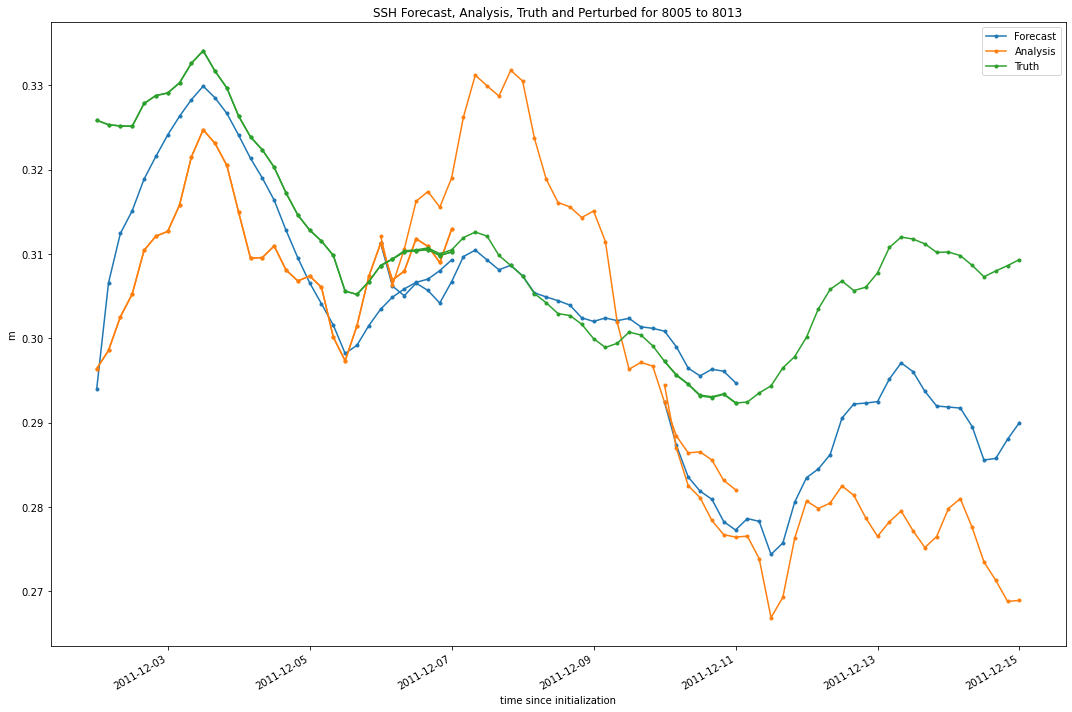

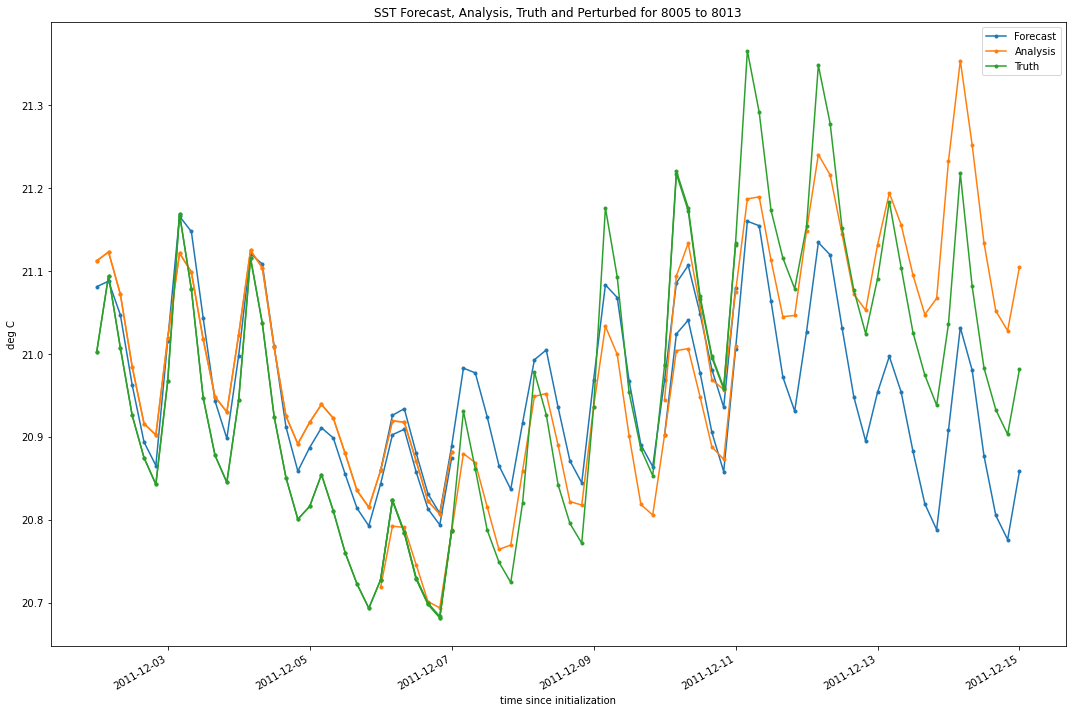

In [ ]:
### Close up plot of time series of forecast and truth

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =pertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure(figsize=[15,10])
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",marker='.',linestyle='-',label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",marker='.',linestyle='-',label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",marker='.',linestyle='-',label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",marker='.',linestyle='-',label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",marker='.',linestyle='-',label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",marker='.',linestyle='-',label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=[15,10])
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",marker='.',linestyle='-',label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",marker='.',linestyle='-',label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",marker='.',linestyle='-',label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",marker='.',linestyle='-',label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",marker='.',linestyle='-',label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",marker='.',linestyle='-',label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

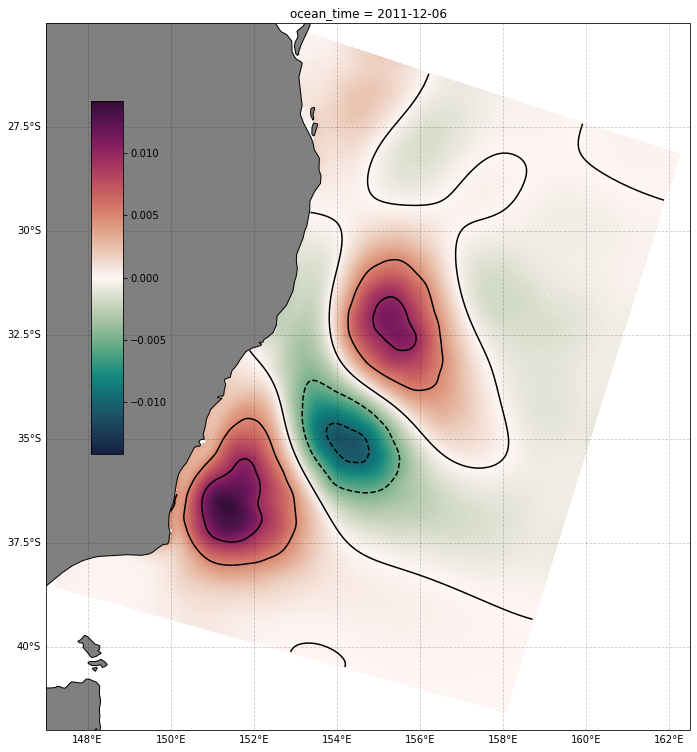

In [ ]:
# Split into 4 hourly blocks of data, but differenced from field at time[0]

datelist = np.array(range(timeRange[0],timeRange[1],4))
provValue=405
timeOutputs=1

dates = '8009'
filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
sshAnalysis2=xr.open_dataset(filenameAnalysis).zeta.load()
sshAnalysis_time2 = sshAnalysis2.isel(ocean_time=0).squeeze()

dates = '8005'
filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
sshAnalysis1=xr.open_dataset(filenameAnalysis).zeta.load()
sshAnalysis_time1 = sshAnalysis1.isel(ocean_time=-7).squeeze()

toPlotData = sshAnalysis_time2 - sshAnalysis_time1

fig = plt.figure(figsize=(13,13))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.curl", "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(toPlotData,pcol_kwargs=pcol_params, cont_kwargs=cont_params)



In [ ]:
print(sshAnalysis2.isel(ocean_time=0).ocean_time.values)
print(sshAnalysis1.isel(ocean_time=-7).ocean_time.values)



2011-12-06T00:00:00.000000000
2011-12-06T00:00:00.000000000


Text(0.5, 1.0, 'difference in ubar for 8009 at 2011-12-06T00:00 and 8005 at 2011-12-06T00:00')

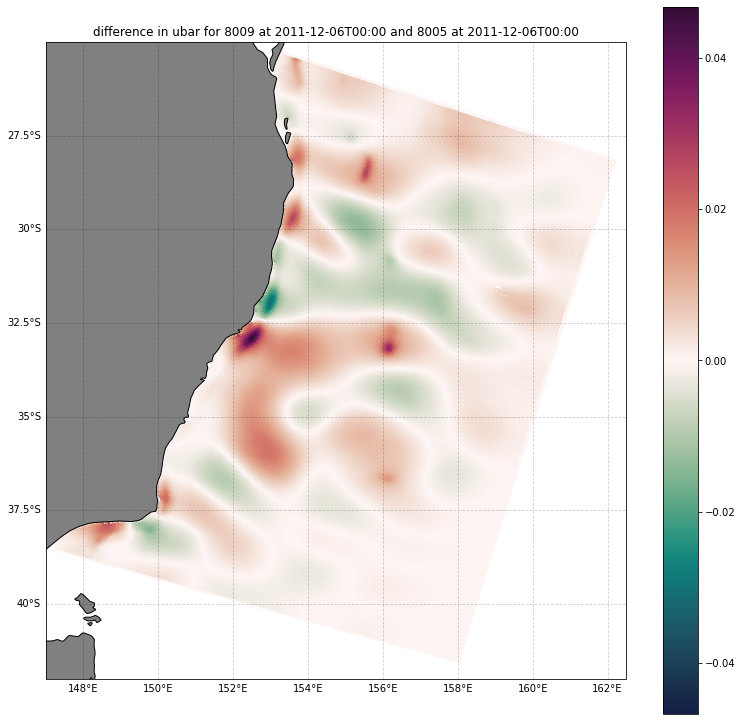

In [ ]:

datelist = np.array(range(timeRange[0],timeRange[1],4))
provValue=405
timeOutputs=1

dates = '8009'
filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
ubarAnalysis2=xr.open_dataset(filenameAnalysis).ubar.load()
ubarAnalysis_time2 = ubarAnalysis2.isel(ocean_time=0).squeeze()

dates = '8005'
filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
ubarAnalysis1=xr.open_dataset(filenameAnalysis).ubar.load()
ubarAnalysis_time1 = ubarAnalysis1.isel(ocean_time=-7).squeeze()

toPlotData = ubarAnalysis_time2 - ubarAnalysis_time1

fig = plt.figure(figsize=(13,13))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_u','lat_u',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
gl = ax.gridlines(draw_labels=True,
                color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False     
plt.colorbar(im, ax=ax)
date1=np.datetime_as_string(ubarAnalysis_time1.coords['ocean_time'].values)
date2=np.datetime_as_string(ubarAnalysis_time2.coords['ocean_time'].values)
ax.set_title('difference in ubar for 8009 at '+date2[:-13]+' and 8005 at '+date1[:-13])


In [ ]:
date1

numpy.datetime64('2011-12-06T00:00:00.000000000')

In [ ]:
        time1=sshAnalysis.coords['ocean_time'].values[tChunk]
        time2=sshAnalysis.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 

In [ ]:
STOP HERE

SyntaxError: invalid syntax (<ipython-input-18-a6774c8535dd>, line 1)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


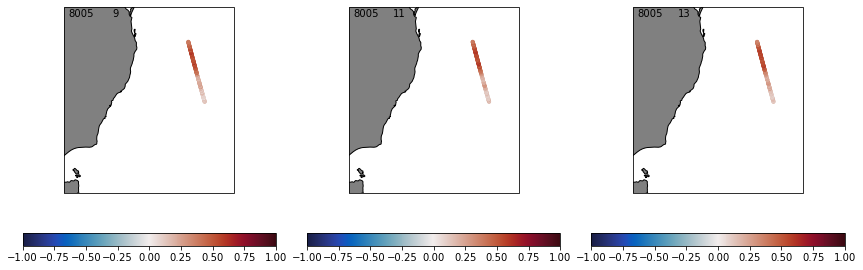

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.obs_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


8005.375
<xarray.DataArray 'obs_value' ()>
array(0.35933071)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.36266427)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.36246533)


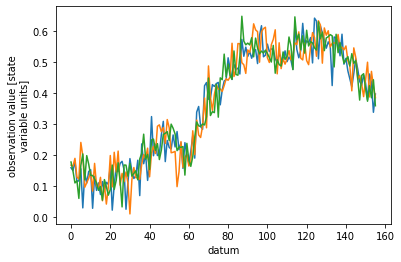

In [ ]:
# plots of obs_value (which is the value we duplicated and put into the original obs file)

dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.obs_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

8005.375
<xarray.DataArray 'NLmodel_value' ()>
array(0.26665956)
8005.4583
<xarray.DataArray 'NLmodel_value' ()>
array(0.24717522)
8005.5416
<xarray.DataArray 'NLmodel_value' ()>
array(0.25649843)


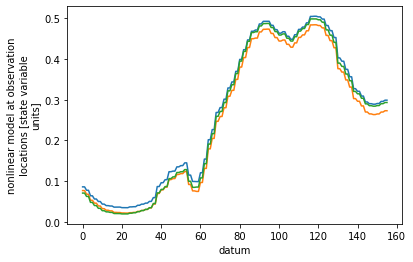

In [ ]:
# plots of NLmodel_value which is the model value at the obs value point and time.

dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

### Compare high res run mod file and his file.

In [ ]:
obsPath = '../data/raw/eac_obs_8005.nc'
hisPath = '../data/raw/'
modPath = '../data/raw/eac_mod_08005.nc'
truthPath = '../data/raw/run1/truth/outer_his_08005.nc'

mod = xr.open_dataset(modPath)
obs = xr.open_dataset(obsPath)
hisFor = xr.open_dataset(hisPath+prefixForecast+'08005.nc')
hisAna = xr.open_dataset(hisPath+prefixAnalysis+'08005.nc')
hisTru = xr.open_dataset(truthPath)


In [ ]:
# import pandas as pd
# pd.to_datetime(8005.02045,unit='d')


In [ ]:
# lst = [8005.34764204, 8005.34764606, 8005.34765007]
# lstDate = []
# for l in lst:
#     lstDate.append(DT.timedelta(days=l))

# print(lstDate)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


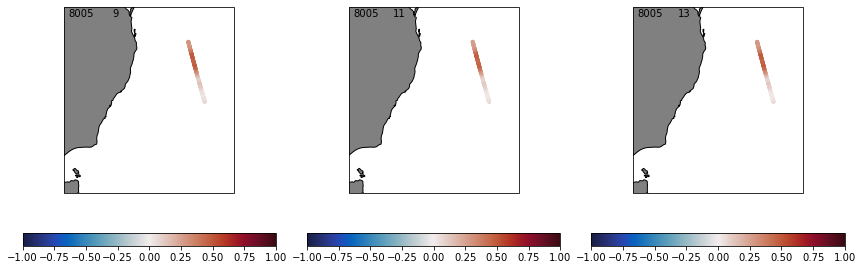

In [ ]:

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()

In [ ]:
    # epoch = np.datetime64('1990-01-01 00:00')
    # searchTime=np.timedelta64(int(tRangeStart*86400),'s') + epoch, print(searchTime, int(tRangeStart*86400))
    # endTime=np.timedelta64(int(tRangeStart*86400+2*3600),'s') + epoch, print(endTime, int(tRangeStart*86400+2*3600))

8005.375
<xarray.DataArray 'NLmodel_value' ()>
array(0.26665956)
8005.4583
<xarray.DataArray 'NLmodel_value' ()>
array(0.24717522)
8005.5416
<xarray.DataArray 'NLmodel_value' ()>
array(0.25649843)


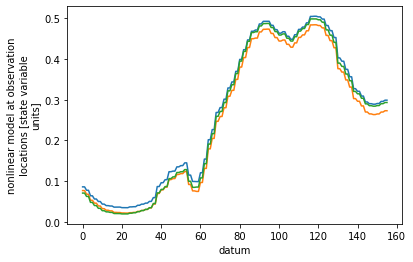

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

In [ ]:
# import pandas as pd
# epochRun = '1990-01-01 00:00'
# pd.to_datetime(epochRun)
# pd.to_datetime(8005.375,unit='d') + pd.to_datetime(epochRun)

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas
    epoch
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  


epochY,epochm,epochd,epochH,epochM=1990,1,1,0,0

print(serial_day_to_datestring(8005))
print(datestring_to_serial_day('2011-12-05 14:30'))

2011-12-02 00:00
8008.604166666667


1991-12-02 09:00:00
1991-12-02 12:59:54.240000
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


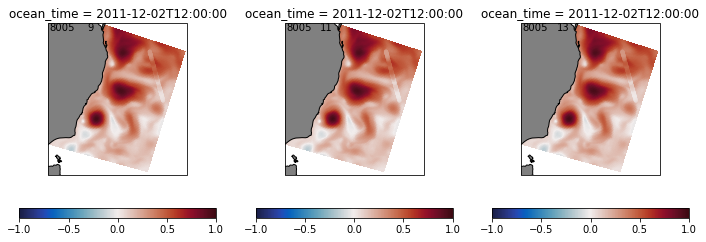

In [ ]:
import pandas as pd
print(pd.to_datetime(8005.375,unit='d'))
print(pd.to_datetime(8005.5416,unit='d'))


timeRange = slice('2011-12-02 09:00:00', '2011-12-02 13:00:00')

hisInTime = hisTru.sel(ocean_time=timeRange).isel(ocean_time=0)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)
zeta = hisInTime.zeta
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=zeta.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, vmin=-1, vmax=1, cmap=cmaps.cmocean_balance)
    # im = zeta.plot.pcolormesh()
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
# plt.tight_layout()

<ipython-input-100-2e43d07b1d7b>:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value')
<ipython-input-100-2e43d07b1d7b>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value')
<xarray.DataArray 'NLmodel_value' ()>
array(0.35384032)


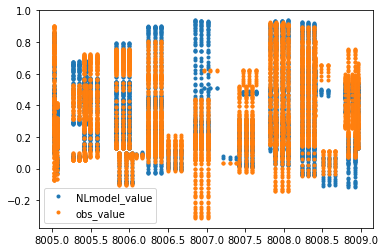

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([dStart, dEnd])
pRange=(405)


v=mod.NLmodel_value.where(mod.obs_provenance==pRange)
vobs=mod.obs_value.where(mod.obs_provenance==pRange)

lo=mod.obs_lon.where(mod.obs_provenance==pRange)
la=mod.obs_lat.where(mod.obs_provenance==pRange)
t=mod.obs_time.where(mod.obs_provenance==pRange)

fig = plt.figure()
ax = plt.axes()
ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value')
ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value')
ax.legend()
# vobs.plot(marker='.')
print(v.mean())

### try again with new finalised obs files

In [ ]:
obsPath = '../data/raw/run1/new_truth/eac_obs_8005.nc'


obs = xr.open_dataset(obsPath)

8005.375
<xarray.DataArray 'obs_value' ()>
array(0.35933071)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.36266427)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.36246533)


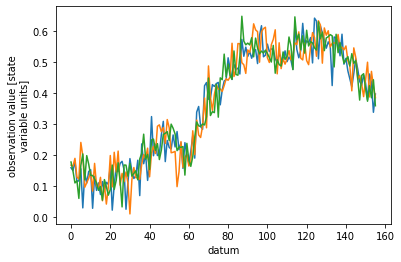

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


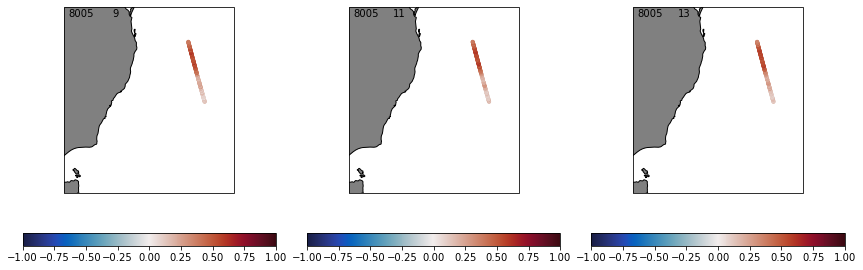

In [ ]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009


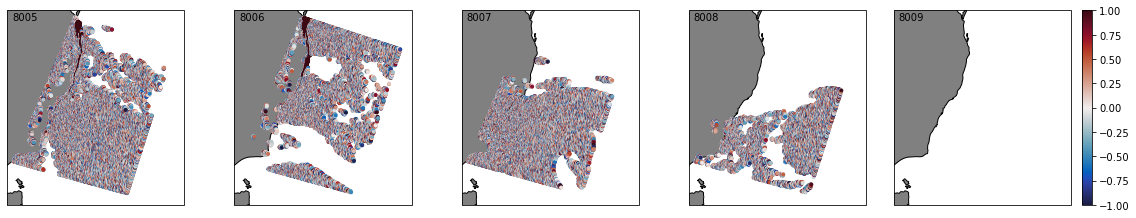

In [ ]:

tRange=np.arange(8005,8013,1)
pRange=(340)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

In [ ]:
# timeSlice = slice('2011-12-02 09:00:00', '2011-12-02 17:00:00')

# fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# hisFor.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).zeta.plot.pcolormesh(ax=axes[0])
# hisAna.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).zeta.plot.pcolormesh(ax=axes[1])
# hisTru.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).zeta.plot.pcolormesh(ax=axes[2])

KeyboardInterrupt: 

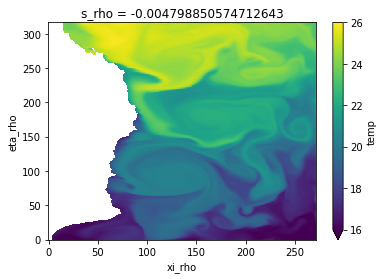

In [ ]:
hisTru.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).temp.isel(s_rho=-1).plot.pcolormesh(vmin=16,vmax=26)


### NOW INVESTIGATE SST VALUES >:O

<ipython-input-193-903c484cac07>:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value',zorder=10)
<ipython-input-193-903c484cac07>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value',zorder=9)
<xarray.DataArray 'NLmodel_value' ()>
array(0.05073394)


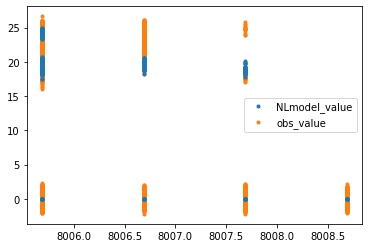

In [ ]:
obsPath = '../data/raw/eac_obs_8005.nc'
modPath = '../data/raw/eac_mod_08005.nc'

obs = xr.open_dataset(obsPath)
mod = xr.open_dataset(modPath)


dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(340)

tRange=np.array([dStart, dEnd])


v=mod.NLmodel_value.where(mod.obs_provenance==pRange).sel(Nouter=0)
vobs=obs.obs_value.where(mod.obs_provenance==pRange)

lo=mod.obs_lon.where(mod.obs_provenance==pRange)
la=mod.obs_lat.where(mod.obs_provenance==pRange)
t=mod.obs_time.where(mod.obs_provenance==pRange)

fig = plt.figure()
ax = plt.axes()
ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value',zorder=10)
ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value',zorder=9)
ax.legend()
print(v.mean())



<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009


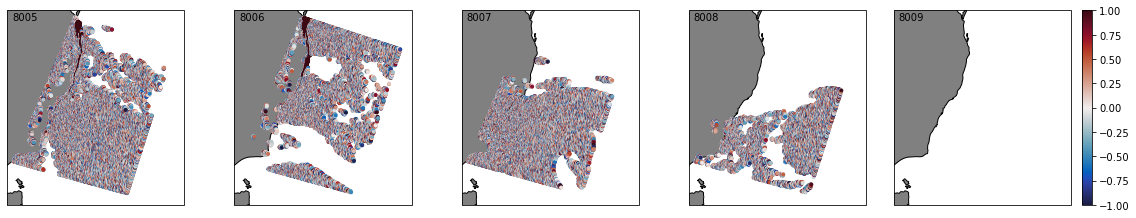

In [ ]:

tRange=np.arange(8005,8013,1)
pRange=(340)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009


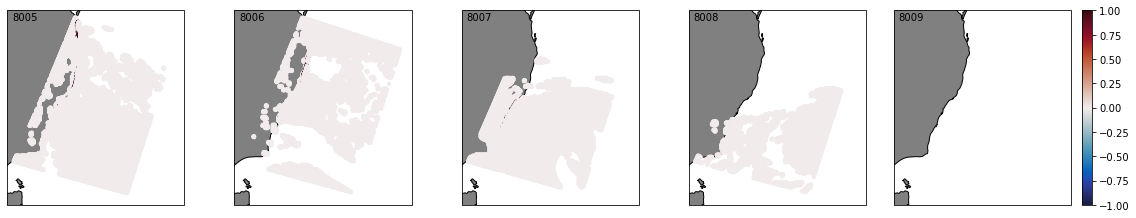

In [ ]:
tRange=np.arange(8005,8013,1)
pRange=(340)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_final.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

In [ ]:
## raw SST obs

raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/SST_Himawari_synth/obs_SST_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values)
print(raw.obs_Zgrid.values)


[0. 0. 0. ... 0. 0. 0.]
[30. 30. 30. ... 30. 30. 30.]


In [ ]:
## raw SSH obs
raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/SSH_alongtrack/obs_SSH_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values, raw.obs_depth.values.mean())
print(raw.obs_Zgrid.values, raw.obs_Zgrid.values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[30. 30. 30. ... 30. 30. 30.] 30.0


In [ ]:
## merged obs from verification directory

raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/obs/eac_obs_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values, raw.obs_depth.values.mean())
print(raw.obs_Zgrid.values, raw.obs_Zgrid.values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[30. 30. 30. ... 30. 30. 30.] 30.0


In [ ]:
## outputted mod file for extracting the NLmodel_value 

raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/mod/eac_mod_08005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values, raw.obs_depth.values.mean())
print(raw.obs_Zgrid.values, raw.obs_Zgrid.values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[0. 0. 0. ... 0. 0. 0.] 0.0


In [ ]:
## final obs after verification

raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/obs_final/eac_obs_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values, raw.obs_depth.values.mean())
print(raw.obs_Zgrid.values, raw.obs_Zgrid.values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[30. 30. 30. ... 30. 30. 30.] 30.0
